In [1]:
# HIDE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model

%matplotlib inline

Using TensorFlow backend.
/Users/stijntonk/miniconda3/envs/fair-ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Towards fairness in machine learning with adversarial networks 

## Introduction
From credit ratings to housing allocation, machine learning models are increasingly being used to automate the decision making processes in both business and government. With this growing impact on society, more and more concerns are being voiced about the loss of transparency, accountability and fairness of the algorithms making the decisions. We as machine learners and data scientists need to step-up our game and look for ways to mitigate emergent discrimination in our models. We need to make sure that our predictions do not disproportionately hurt (or, benefit) people with certain sensitive attribute values (e.g., gender, ethnicity).

Luckily, [NIPS 2017](https://blog.godatadriven.com/gdd-nips-2017) showed us that the field of machine learning is actively investigating how to bring tansparancy and fairness to predictive models. Roughly speaking this effort can be split into two approaches. The first approach focusses on model interpretability and transparancy by allowing deeper interogation of complex, blackbox models. The second takes the route of constraining and changing the optimization objective such that trained models are more robust and fair in their predictions. 

In this blog post we will take a look at the second approach and show you how adversarial networks can be used for building fairer predictive models. This work is based on the work the 2017 NIPS paper [Learning to Pivot with Adversarial Networks](https://papers.nips.cc/paper/6699-learning-to-pivot-with-adversarial-networks) by Louppe et al. Most of the code in post itself will be omitted, however you can find jupyter notebook containing all the code [here TODO](...).

## Predicting income levels

The dataset we use in this blog post is the [adult UCI](https://archive.ics.uci.edu/ml/datasets/Adult) dataset, which is also referred to as "Census Income" dataset. The task at hand is to predict whether or not someone makes over 50K dollar a year, in other words a binary classification task. It is not hard to imagine how financial institutions use these kind of data for building models that determine wether or not someone is eligible for a loan, or to determine the height of an insurance premium.

We get started by reading in the data and parse it into the following three datasets:

- **features $X$** which contain the input atributtes that the model uses for making the predictions, these atributtes are: `age`, `workclass`, `fnlwgt`, `education`, `education_num`, `martial_status`, `occupation`, `relationship`, `capital_gain`, `capital_loss`, `hours_per_week` and `country`;
- **targets $y$** which contain the binary class labels the model needs to learn to predict, where $y\in\left\{Income>50K, Income\leq 50K\right\}$;
- and finally, **sensitive attributes $Z$** for which we want the prediction to be fair, these are:
  - attribute `race` where $z_{race}\in\left\{Black, White\right\}$;
  - attribute `sex` where $z_{sex}\in\left\{Female, Male\right\}$.
  
It is important to note that the sensitive attributes `race` and `sex` are **not** part the features $X$, they only occur in the sensitive attribute data $Z$.

In [2]:
# HIDE
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'martial_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  [lambda df: df['race'].isin(['White','Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race','sex']
    Z = input_data[sensitive_attribs]\
        .assign(race=lambda df: (df['race']=='White').astype(int),
                sex=lambda df: (df['sex']=='Male').astype(int))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target']=='>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
        .drop(columns=['target','race','sex'])
        .fillna('Unknown')
        .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitive Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X,y,Z

In [5]:
# load ICU data set
X,y,Z = load_ICU_data('adult.data')

features X: 30940 samples, 94 attributes
targets y: (30940,) samples
sensitive Z: 30940 samples, 2 attributes


Next, we split the data into train and test sets, where the split is 50/50. Note, that we use stratified splitting to make sure the percentage positive and negative examples are the same in both sets. Also, the feature data is scaled using standard scaling.

In [6]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=1/2, stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

Now, we are ready to train a neural net on the train data. We use Keras to fit a simple three layer network with ReLU activations and dropout regularization. The output of the net is a single node with sigmoid activation. As a result, it will predict $P(Income>50K)$, or in words, "the probability of the person's income being more than 50K".

In [7]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation="relu")(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation="relu")(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation="sigmoid")(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

clf = nn_classifier(n_features=X_train.shape[1])
history = clf.fit(X_train, y_train, epochs=20, verbose=0)

Finally, we use the trained classfier to make income level predictions on the test data. We will determine the performance of the classifier by computing both the [Area Under the Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) and the accuracy score of resulting predictions.

In [8]:
y_pred = pd.Series(clf.predict(X_test).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.0f}%")

ROC AUC: 0.91
Accuracy: 86%


With a ROC AUC of above 0.9 and a prediction accuracy of 85% we can say that our classifier performs pretty good! However, how about the 'fairness' of our trained model and the prediction it produced?

## Predictions fairness

Before we start our investigation into the fairness of our model, it is important to point out that the two sensitive attributes `race` and `sex` are **not** part of the feature data $X$. This means that our trained model could not use this information for learning how to its predictions. Now, one might be tempted to think that merely excluding sensitive attributes from the training data is enough to obtain a fair model. However, as we will also see next, that is hardly ever the solution. Often it still results in a unfair models due to data being baised given these sensistive attributes.

We start our investigation by analyzing the output distributions of our classifier in the context for each sensitive attributes. In the figure below we plot the prediction distrubutions the model outcome $P(Income>50K)$ given each of the sensistive attributes, using the predictions made on the test data.

In [9]:
# HIDE
def plot_distributions(y, Z):
    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    legend={'race':['Black','White'],
                'sex':['Female','Male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0,1]:
            ax = sns.distplot(y[Z[attr]==attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,8)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx==0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{Income>50K}}|z_{{{}}})$'.format(attr))
    fig.tight_layout()

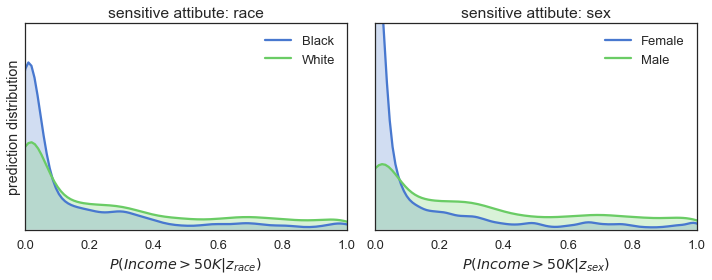

In [10]:
plot_distributions(y_pred, Z_test)

Considering the green and blue prediction distributions in plots above we find that, compaired to the green, the blue curve shows a high peak at low end end of the probability range. This means our classifier has a much higher probability of predicting an income lower than 50K for the attributes Black and Female compaired to White and Male. It is quite clear from these plots that the prediction made on test set are far from fair.

The prediction distibutions plots give us more a qualatative measure of 'how' unfair our classifier is. For quantifying this, we can take inspiration from the U.S. Equal Employment Opportunity Commission. They use the so-called [80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80%_rule) to quantify disparate impact on a group of people of a protected characteristic. In their paper, [Fairness Constraints: Mechanisms for Fair Classification](https://arxiv.org/pdf/1507.05259.pdf), Zafar et al. show how a more generic version of this rule, the p%-rule, can be used to quantify fairness of a classifier. This more general rule is defined as follows:

> A classifier that makes a binary class prediction $\hat{y} \in \left\{0,1 \right\}$ given a binary sensitive attribute $z\in \left\{0,1 \right\}$ satifies the p%-rule
if the following inequality holds:
>
>$$\min\left(\frac{P(\hat{y}=1|z=1)}{P(\hat{y}=1|z=0)}, \frac{P(\hat{y}=1|z=0)}{P(\hat{y}=1|z=1)}\right)\geq\frac{p}{100}$$

The rule states the ratio between the probability of a positive outcome given the sensitive attribute being true and the same probability given the sensitive attribute being false is no less than p:100. So, a completely fair classifier satifies a 100%-rule. And, following U.S. Equal Employment Opportunity Commission, we can say that an unfair classifier satisfies a %p-rule with $p$ is smaller than 80%.

Lets compute which %p-rules our trained classifier adheres to:

In [11]:
# HIDE
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values==1]>threshold if threshold else y_pred[z_values==1]
    y_z_0 = y_pred[z_values==0]>threshold if threshold else y_pred[z_values==0]
    odds = y_z_1.mean()/y_z_0.mean()
    return np.min([odds, 1/odds])*100

In [13]:
print("The classifier satifies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

The classifier satifies the following %p-rules:
	given attribute race; 45%-rule
	given attribute sex;  35%-rule


We find that for both sensitive attributes the classifier satisfies a p%-rule that is significantly smaller than 80%. So, we find that classifier will be quite unfair in its predictions.

## Adverserial networks

In [25]:
from IPython import display
%matplotlib inline
def plot_losses(i, losses, n_iter, lam):
    display.clear_output(wait=True)
    
    ax1 = plt.subplot(311)
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.grid()
    
    ax2 = plt.subplot(312, sharex=ax1)
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.grid()
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    plt.xlim(0,n_iter)
    plt.grid()
    
    plt.show()
    #display.display(plt.gcf())

In [26]:
from keras.losses import binary_crossentropy

class FairClassifier(object):
    
    def __init__(self, n_features, n_targets, n_sensitive, lambda_param):
        self.lambda_param = lambda_param
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(n_targets,))
        
        clf_net = self._create_clf_net(clf_inputs, n_targets)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net)
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
    
    def _binary_crossentropy(self, c=1.0):
        def loss(*args, **kwargs):
            return c*binary_crossentropy(*args, **kwargs)
        return loss
        
    def _create_clf_net(self, inputs, n_targets):
        dense1 = Dense(32, activation="relu")(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation="relu")(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation="relu")(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        outputs = Dense(n_targets, activation="sigmoid")(dropout3)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(32, activation="relu")(inputs)
        dense2 = Dense(32, activation="relu")(dense1)
        dense3 = Dense(32, activation="relu")(dense2)
        outputs = Dense(n_sensitive, activation="sigmoid")(dense3)
        return Model(inputs=[inputs], outputs=[outputs])

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf_net.compile(loss=self._binary_crossentropy(), optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs), 
                                                    adv_net(clf_net(inputs))])
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        clf_w_adv.compile(loss=[self._binary_crossentropy(c=1.0), 
                          self._binary_crossentropy(c=-self.lambda_param)], 
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net):
        adv = Model(inputs=[inputs], outputs=[adv_net(clf_net(inputs))])
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=[self._binary_crossentropy()], optimizer='adam')
        return adv

    def pretrain(self, x, y, z, epochs=10, verbose=0):
        print('Pretraining of classifier without adverserial...')
        self._trainable_clf_net(True)
        self._clf.fit(x, y, epochs=epochs, verbose=verbose)
        print('Pretraining of adverserial classifier...')
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        self._adv.fit(x, z, epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, n_iter=250, batch_size=128):
        losses = {"L_f": [], "L_r": [], "L_f - L_r": []}
        if validation_data is not None:
            x_val, y_val, z_val = validation_data
        for i in range(n_iter):
            if validation_data is not None:
                l = self._clf_w_adv.evaluate(x_val, [y_val, z_val], verbose=0)    
            losses["L_f - L_r"].append(l[0][None][0])
            losses["L_f"].append(l[1][None][0])
            losses["L_r"].append(-l[2][None][0])

            if i % 5 == 0:
                plot_losses(i, losses, n_iter, self.lambda_param)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.train_on_batch(x.values[indices], [y.values[indices], z.values[indices]])
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x, z, batch_size=batch_size, epochs=1, verbose=0)
        

In [27]:
clf = FairClassifier(X_train.shape[1], 1, Z_train.shape[1], 200)

In [28]:
clf.pretrain(X_train, y_train, Z_train, verbose=0)

Pretraining of classifier without adverserial...
Pretraining of adverserial classifier...


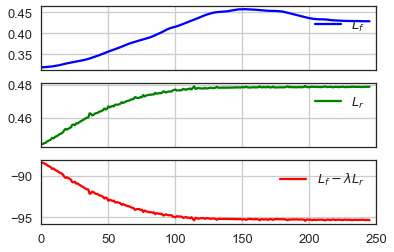

In [29]:
clf.fit(X_train, y_train, Z_train, validation_data=(X_test, y_test, Z_test))

ROC AUC: 0.83
Accuracy: 0.82


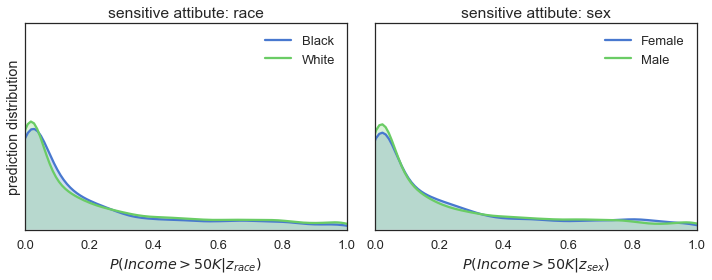

In [32]:
y_pred = pd.Series(clf.predict(X_test).ravel(), index=y_test.index)
plot_distributions(y_pred, Z_test)
print('ROC AUC: {0:.2f}'.format(roc_auc_score(y_test, y_pred)))
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, (y_pred>0.5))))

In [34]:
print("The classifier satifies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

The classifier satifies the following %p-rules:
	given attribute race; 83%-rule
	given attribute sex;  99%-rule
